# Get Score from loadmonitor


## Notebook Preps


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

In [2]:
# change current directory to the project directory
import os
os.chdir('../../../')

In [3]:
!pip install -r ai/requirements.txt --user
!pip install python-dotenv

First let's set environment variables. (in .env file in ai folder) (Note: also run the proxy script) Example would be

```env
CLUSTER_NAME=dev
DB_USER=asdf
DB_PASS=asdf
DB_ADDR=127.0.0.1
DB_PORT=5432
DB_NAME=lynus
DB_MODE=disable
S3_ENDPOINT=sos-at-vie-1.exo.io
S3_ACCESS_KEY=asdf
S3_SECRET_KEY=asdf
S3_SECURE=1
EMPA_ADDR=http://127.0.0.1:9000/
WEATHER_API_KEY=asdf
```


In [4]:
from dotenv import load_dotenv

load_dotenv("./ai/.env", override=True)

True

### Fetch all Models


In [5]:
import psycopg
import pandas as pd

# Get DB connection and all EMS models

try:
    # Establish a connection to the PostgreSQL database
    connection = psycopg.connect(
        dbname=os.environ["DB_NAME"],
        user=os.environ["DB_USER"],
        password=os.environ["DB_PASS"],
        host=os.environ["DB_ADDR"],
        port=os.environ["DB_PORT"]
    )

    # Create a cursor object to interact with the database
    cursor = connection.cursor()

    cursor.execute("SELECT models.id as model_id, models.r->'data'->>'type' as model_type, project.name as project_name, models.r->>'project_id' as project_id \
FROM models \
JOIN project ON models.r->>'project_id'= project.id::text \
WHERE models.r -> 'data' ->> 'type' LIKE '%LoadMonitor%' \
")
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Get column names


except psycopg.Error as e:
    print(f"Unable to connect to the database. Error: {e}")

finally:
    # Close the cursor and connection, regardless of whether the try block succeeds or raises an exception
    if connection:
        cursor.close()
        connection.close()
        print("Connection closed.")

# Convert the result to a Pandas DataFrame
model_df = pd.DataFrame(result, columns=columns)
model_df

Connection closed.


,model_id,model_type,project_name,project_id
0,6d6b9d77-e7ef-47e3-9b6f-8b29559d7dad,LoadMonitor,Demo Site #1,9cd72c35-5f60-49af-9bb5-b551ac54c00a
1,9498cd84-ad10-4016-b218-7d47c1dae811,LoadMonitor,Demo Site #2,c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc
2,8b1a11ce-7a77-4081-a55f-b1f72a30a1d3,LoadMonitor,Bäckerei-Filiale #1,42cf3b23-700d-4275-a072-1301ce2666ee
3,12f5dffd-0fc5-40fc-885a-33c060fb6a15,LoadMonitor,Demo Site #2,c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc
4,0d0c71a2-bc67-4589-b202-8451d83e9394,LoadMonitor,clone: BMS Barac Michael,15410e61-b610-45b5-8f44-ee3f7b94538f


In [6]:
from ai.interface.model_holder import ModelHolder
from ai.model_holder.load_monitor_model_holder import LoadMonitorModelHolder

index = 3
train_duration_weeks = 5

model_id = str(model_df.iloc[index]["model_id"])
model_holder_type = LoadMonitorModelHolder
model_holder = ModelHolder.load_model_holder_from_s3(
    model_id, model_holder_type, model_load=False, status_load=False)
data_holder = model_holder.get_dh()

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
data_holder.name

'lademonitor'

In [11]:
data_holder.created_at

'2024-05-14T13:21:36.015290'

In [7]:
# today
from datetime import datetime
end = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

# start date = end - 7 days
start = end - pd.Timedelta(days=14)
start_i = int(start.timestamp())
end_i = int(end.timestamp())

In [7]:
from ai.utils.http_utils import append_data_to_dataframe_http, fetch_data_from_http

df = data_holder.get_data(start=start_i, end=end_i, interval="15m")
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt
ts,
2024-05-28 00:00:00+02:00,5.22
2024-05-28 00:15:00+02:00,5.18
2024-05-28 00:30:00+02:00,5.12
2024-05-28 00:45:00+02:00,5.02
2024-05-28 01:00:00+02:00,4.87
...,...
2024-06-10 23:00:00+02:00,4.99
2024-06-10 23:15:00+02:00,4.93
2024-06-10 23:30:00+02:00,4.88


In [8]:
start_i, end_i

(1716847200, 1718056800)

In [8]:
data_holder.get_report(start=start_i, end=end_i)

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]
ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')
c:\Users\jpeff\Documents\GitHub\efficientIO\ai\data_holder\load_monitor_data_holder.py:316: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. 

[{'ts': 1716933600,
  'load_after_baking_window': True,
  'load_in_baking_window': False,
  'load_before_baking_window': False,
  'load_operating_buffer_end': True,
  'load_operating_buffer_start': False,
  'load_baking_window_before_buffer_start': False,
  'load_start_operating_buffer_end': False,
  'first_load_start': 1716989400.0},
 {'ts': 1717365600,
  'load_after_baking_window': True,
  'load_in_baking_window': False,
  'load_before_baking_window': False,
  'load_operating_buffer_end': False,
  'load_operating_buffer_start': False,
  'load_baking_window_before_buffer_start': False,
  'load_start_operating_buffer_end': False,
  'first_load_start': 1717408800.0},
 {'ts': 1717538400,
  'load_after_baking_window': True,
  'load_in_baking_window': True,
  'load_before_baking_window': True,
  'load_operating_buffer_end': True,
  'load_operating_buffer_start': True,
  'load_baking_window_before_buffer_start': True,
  'load_start_operating_buffer_end': False,
  'first_load_start': 1717577

In [13]:
v = data_holder.get_prediction_variable()
data = fetch_data_from_http(v, data_holder.project_id, start_i, end_i, "15m")
df = append_data_to_dataframe_http(df, data, v)
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load
ts,,,
2024-05-23 00:00:00+02:00,4.98,2024-05-23 00:00:00+02:00,0
2024-05-23 00:15:00+02:00,4.99,2024-05-23 00:15:00+02:00,0
2024-05-23 00:30:00+02:00,4.93,2024-05-23 00:30:00+02:00,0
2024-05-23 00:45:00+02:00,4.88,2024-05-23 00:45:00+02:00,0
2024-05-23 01:00:00+02:00,4.89,2024-05-23 01:00:00+02:00,0
...,...,...,...
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0
2024-06-05 23:30:00+02:00,5.81,2024-06-05 23:30:00+02:00,0


In [14]:
from ai.utils.holiday_workday_utils import load_project_operating_hours

operating_hours = load_project_operating_hours(data_holder.project_id)
operating_hours

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]


{'friday': {'end': None, 'start': None, 'enabled': False},
 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0},
  'start': {'hours': 11, 'minutes': 28, 'seconds': 0},
  'enabled': True},
 'sunday': {'end': None, 'start': None, 'enabled': False},
 'holiday': {'end': None, 'start': None, 'enabled': False},
 'tuesday': {'end': None, 'start': None, 'enabled': False},
 'saturday': {'end': None, 'start': None, 'enabled': False},
 'thursday': {'end': None, 'start': None, 'enabled': False},
 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0},
  'start': {'hours': 13, 'minutes': 28, 'seconds': 0},
  'enabled': True}}

In [15]:
data_holder.baking_window_duration

120

<Axes: xlabel='ts'>

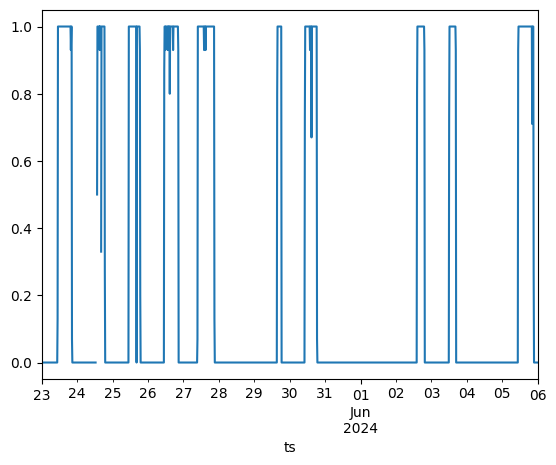

In [16]:
df['LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load'].plot()

In [17]:
project_id = data_holder.project_id
project_id

'c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc'

In [18]:
from ai.utils.holiday_workday_utils import get_week_holiday, load_project_holidays, get_weekday

holidays = load_project_holidays(project_id)


def get_week_holiday_for_df(val):
    return get_week_holiday(project_id, val, holidays=holidays)


apply_func = get_week_holiday_for_df if holidays is not None else get_weekday

df['weekday'] = df['ts'].apply(apply_func)
df

ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')


,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday
ts,,,,
2024-05-23 00:00:00+02:00,4.98,2024-05-23 00:00:00+02:00,0,thursday
2024-05-23 00:15:00+02:00,4.99,2024-05-23 00:15:00+02:00,0,thursday
2024-05-23 00:30:00+02:00,4.93,2024-05-23 00:30:00+02:00,0,thursday
2024-05-23 00:45:00+02:00,4.88,2024-05-23 00:45:00+02:00,0,thursday
2024-05-23 01:00:00+02:00,4.89,2024-05-23 01:00:00+02:00,0,thursday
...,...,...,...,...
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday
2024-06-05 23:30:00+02:00,5.81,2024-06-05 23:30:00+02:00,0,wednesday


In [19]:
df['start_operating_hours'] = df['weekday'].apply(
    lambda x: operating_hours[x]['start'])
df['end_operating_hours'] = df['weekday'].apply(
    lambda x: operating_hours[x]['end'])
df

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours
ts,,,,,,
2024-05-23 00:00:00+02:00,4.98,2024-05-23 00:00:00+02:00,0,thursday,None,None
2024-05-23 00:15:00+02:00,4.99,2024-05-23 00:15:00+02:00,0,thursday,None,None
2024-05-23 00:30:00+02:00,4.93,2024-05-23 00:30:00+02:00,0,thursday,None,None
2024-05-23 00:45:00+02:00,4.88,2024-05-23 00:45:00+02:00,0,thursday,None,None
2024-05-23 01:00:00+02:00,4.89,2024-05-23 01:00:00+02:00,0,thursday,None,None
...,...,...,...,...,...,...
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-06-05 23:30:00+02:00,5.81,2024-06-05 23:30:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"


In [27]:
df_without_na = df.dropna()
df_without_na

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours
ts,,,,,,
2024-05-27 00:00:00+02:00,5.14,2024-05-27 00:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}"
2024-05-27 00:15:00+02:00,5.09,2024-05-27 00:15:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}"
2024-05-27 00:30:00+02:00,5.04,2024-05-27 00:30:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}"
2024-05-27 00:45:00+02:00,4.99,2024-05-27 00:45:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}"
2024-05-27 01:00:00+02:00,4.94,2024-05-27 01:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}"
...,...,...,...,...,...,...
2024-06-05 22:45:00+02:00,6.07,2024-06-05 22:45:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}"


In [32]:
import datetime
import math
buffer = 1  # 1 hour buffer
baking_window = math.floor(data_holder.baking_window_duration / 60)  # convert to hours
# Convert JSON time to datetime.time object

df_without_na['start_buffer_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
    max(x['hours'] - buffer, 0), x['minutes'], x['seconds']))
df_without_na['start_baking_window_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
    max(x['hours'] - baking_window, 0), x['minutes'], x['seconds']))
df_without_na['start_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
    max(x['hours'], 0), x['minutes'], x['seconds']))
df_without_na['end_time'] = df_without_na['end_operating_hours'].apply(
    lambda x: datetime.time(min(x['hours'], 23), x['minutes'], x['seconds']))
df_without_na['end_buffer_time'] = df_without_na['end_operating_hours'].apply(
    lambda x: datetime.time(min(x['hours'] + buffer, 23), x['minutes'], x['seconds']))
df_without_na

C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\1534802502.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['start_buffer_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\1534802502.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['start_baking_window_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\1534802502.py:1

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_buffer_time,start_time,end_time,end_buffer_time,start_baking_window_time
ts,,,,,,,,,,,
2024-05-27 00:00:00+02:00,5.14,2024-05-27 00:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,09:28:00
2024-05-27 00:15:00+02:00,5.09,2024-05-27 00:15:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,09:28:00
2024-05-27 00:30:00+02:00,5.04,2024-05-27 00:30:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,09:28:00
2024-05-27 00:45:00+02:00,4.99,2024-05-27 00:45:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,09:28:00
2024-05-27 01:00:00+02:00,4.94,2024-05-27 01:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,09:28:00
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05 22:45:00+02:00,6.07,2024-06-05 22:45:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,11:28:00
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,11:28:00
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,11:28:00


In [44]:
# Lambda function to check if timestamp is between start and end times
check_baking_window = lambda row: row['start_baking_window_time'] <= row['ts'].time() <= row['start_time']
check_operating_buffer_start = lambda row: row['start_buffer_time'] <= row['ts'].time() <= row['start_time']
check_operating_buffer_end = lambda row: row['end_time'] <= row['ts'].time() <= row['end_buffer_time']
check_before_baking_window = lambda row: row['ts'].time() <= row['start_baking_window_time']

# Apply the lambda function
df_without_na['is_within_baking_window'] = df_without_na.apply(check_baking_window, axis=1)
df_without_na['is_within_operating_buffer_start'] = df_without_na.apply(check_operating_buffer_start, axis=1)
df_without_na['is_within_operating_buffer_end'] = df_without_na.apply(check_operating_buffer_end, axis=1)
df_without_na['is_before_baking_window'] = df_without_na.apply(check_before_baking_window, axis=1)
df_without_na

C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\888715982.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['is_within_baking_window'] = df_without_na.apply(check_baking_window, axis=1)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\888715982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['is_within_operating_buffer_start'] = df_without_na.apply(check_operating_buffer_start, axis=1)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\888715982.py:10: SettingWithCopyWarn

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_buffer_time,start_time,end_time,end_buffer_time,...,is_within_baking_window,is_within_operating_buffer_start,is_within_operating_buffer_end,is_within_baking_window_i,within_baking_window,is_within_operating_buffer_start_i,within_buffer_start,is_within_operating_buffer_end_i,within_buffer_end,is_before_baking_window
ts,,,,,,,,,,,,,,,,,,,,,
2024-05-27 00:00:00+02:00,5.14,2024-05-27 00:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 00:15:00+02:00,5.09,2024-05-27 00:15:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 00:30:00+02:00,5.04,2024-05-27 00:30:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 00:45:00+02:00,4.99,2024-05-27 00:45:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 01:00:00+02:00,4.94,2024-05-27 01:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05 22:45:00+02:00,6.07,2024-06-05 22:45:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,False,False,False,0,8,0,8,0,8,False
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,False,False,False,0,8,0,8,0,8,False
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,False,False,False,0,8,0,8,0,8,False


In [45]:
df_without_na['is_within_baking_window_i'] = df_without_na['is_within_baking_window'].astype(int)
df_without_na['within_baking_window'] = (df_without_na['is_within_baking_window_i'].diff().fillna(0) != 0).cumsum()
df_without_na['is_within_operating_buffer_start_i'] = df_without_na['is_within_operating_buffer_start'].astype(int)
df_without_na['within_buffer_start'] = (df_without_na['is_within_operating_buffer_start_i'].diff().fillna(0) != 0).cumsum()
df_without_na['is_within_operating_buffer_end_i'] = df_without_na['is_within_operating_buffer_end'].astype(int)
df_without_na['within_buffer_end'] = (df_without_na['is_within_operating_buffer_end_i'].diff().fillna(0) != 0).cumsum()
df_without_na

C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\3245849548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['is_within_baking_window_i'] = df_without_na['is_within_baking_window'].astype(int)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\3245849548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['within_baking_window'] = (df_without_na['is_within_baking_window_i'].diff().fillna(0) != 0).cumsum()
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\3245849548.py:3: Setti

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_buffer_time,start_time,end_time,end_buffer_time,...,is_within_baking_window,is_within_operating_buffer_start,is_within_operating_buffer_end,is_within_baking_window_i,within_baking_window,is_within_operating_buffer_start_i,within_buffer_start,is_within_operating_buffer_end_i,within_buffer_end,is_before_baking_window
ts,,,,,,,,,,,,,,,,,,,,,
2024-05-27 00:00:00+02:00,5.14,2024-05-27 00:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 00:15:00+02:00,5.09,2024-05-27 00:15:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 00:30:00+02:00,5.04,2024-05-27 00:30:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 00:45:00+02:00,4.99,2024-05-27 00:45:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
2024-05-27 01:00:00+02:00,4.94,2024-05-27 01:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,False,False,False,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05 22:45:00+02:00,6.07,2024-06-05 22:45:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,False,False,False,0,8,0,8,0,8,False
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,False,False,False,0,8,0,8,0,8,False
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,False,False,False,0,8,0,8,0,8,False


In [53]:


def check_load_before_baking_window(
    row): return row['is_before_baking_window'] and row["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"]


def check_load_in_baking_window(
    row): return row['is_within_baking_window'] and row["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"]


def check_load_after_baking_window(
    row): return not row['is_within_baking_window'] and not row["is_before_baking_window"] and row["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"]


def check_load_operating_buffer_end(
    row): return row["is_within_operating_buffer_end"] and row["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"]


def check_load_operating_buffer_start(
    row): return row["is_within_operating_buffer_start"] and row["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"]


def check_bakin_window_before_buffer_start(
    row): return not row["is_within_operating_buffer_start"] and row['is_within_baking_window'] and row["LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load"]


df_without_na['load_in_baking_window'] = df_without_na.apply(
    check_load_in_baking_window, axis=1)
df_without_na['load_before_baking_window'] = df_without_na.apply(
    check_load_before_baking_window, axis=1)
df_without_na['load_after_baking_window'] = df_without_na.apply(
    check_load_after_baking_window, axis=1)
df_without_na['load_operating_buffer_end'] = df_without_na.apply(
    check_load_operating_buffer_end, axis=1)
df_without_na['load_operating_buffer_start'] = df_without_na.apply(
    check_load_operating_buffer_start, axis=1)
df_without_na['load_baking_window_before_buffer_start'] = df_without_na.apply(
    check_bakin_window_before_buffer_start, axis=1)

df_without_na

C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\4182969787.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['load_in_baking_window'] = df_without_na.apply(
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\4182969787.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_na['load_before_baking_window'] = df_without_na.apply(
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\4182969787.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,weather.c0aad1ed_c6dc_4a0e_b415_8c5e9274f6cc.tt,ts,LM.12f5dffd_0fc5_40fc_885a_33c060fb6a15.load,weekday,start_operating_hours,end_operating_hours,start_buffer_time,start_time,end_time,end_buffer_time,...,within_buffer_start,is_within_operating_buffer_end_i,within_buffer_end,is_before_baking_window,load_in_baking_window,load_before_baking_window,load_after_baking_window,load_operating_buffer_end,load_operating_buffer_start,load_baking_window_before_buffer_start
ts,,,,,,,,,,,,,,,,,,,,,
2024-05-27 00:00:00+02:00,5.14,2024-05-27 00:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,0,0,0,True,False,0,False,False,False,False
2024-05-27 00:15:00+02:00,5.09,2024-05-27 00:15:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,0,0,0,True,False,0,False,False,False,False
2024-05-27 00:30:00+02:00,5.04,2024-05-27 00:30:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,0,0,0,True,False,0,False,False,False,False
2024-05-27 00:45:00+02:00,4.99,2024-05-27 00:45:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,0,0,0,True,False,0,False,False,False,False
2024-05-27 01:00:00+02:00,4.94,2024-05-27 01:00:00+02:00,0,monday,"{'hours': 11, 'minutes': 28, 'seconds': 0}","{'hours': 19, 'minutes': 28, 'seconds': 0}",10:28:00,11:28:00,19:28:00,20:28:00,...,0,0,0,True,False,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05 22:45:00+02:00,6.07,2024-06-05 22:45:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,8,0,8,False,False,False,0,False,False,False
2024-06-05 23:00:00+02:00,5.97,2024-06-05 23:00:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,8,0,8,False,False,False,0,False,False,False
2024-06-05 23:15:00+02:00,5.88,2024-06-05 23:15:00+02:00,0,wednesday,"{'hours': 13, 'minutes': 28, 'seconds': 0}","{'hours': 18, 'minutes': 28, 'seconds': 0}",12:28:00,13:28:00,18:28:00,19:28:00,...,8,0,8,False,False,False,0,False,False,False


In [54]:
df_grouped = df_without_na.groupby(df_without_na['ts'].dt.date).agg(
    load_after_baking_window=('load_after_baking_window', 'any'),
    load_in_baking_window=('load_in_baking_window', 'any'),
    load_before_baking_window=('load_before_baking_window', 'any'),
    load_operating_buffer_end=('load_operating_buffer_end', 'any'),
    load_operating_buffer_start=('load_operating_buffer_start', 'any'),
    load_baking_window_before_buffer_start=('load_baking_window_before_buffer_start', 'any')
).reset_index()
df_grouped

,ts,load_after_baking_window,load_in_baking_window,load_before_baking_window,load_operating_buffer_end,load_operating_buffer_start,load_baking_window_before_buffer_start
0,2024-05-27,True,True,False,True,True,True
1,2024-05-29,True,False,False,False,False,False
2,2024-06-03,True,False,False,False,False,False
3,2024-06-05,True,True,True,True,True,True


In [56]:
import datetime
import math

from ai.utils.holiday_workday_utils import get_week_holiday, load_project_holidays, get_weekday
from ai.utils.holiday_workday_utils import load_project_operating_hours
from ai.data_holder.load_monitor_data_holder import LoadMonitorDataHolder


def get_history(_dh: LoadMonitorDataHolder, _start: int, _end: int, _buffer: int = 1):
    try:
        df = _dh.get_data(start=_start, end=_end, interval="15m")
        v = _dh.get_prediction_variable()
        data = fetch_data_from_http(
            v, _dh.project_id, _start, _end, "15m")
        df = append_data_to_dataframe_http(df, data, v)

        operating_hours = load_project_operating_hours(_dh.project_id)
        holidays = load_project_holidays(_dh.project_id)

        def get_week_holiday_for_df(val):
            return get_week_holiday(_dh.project_id, val, holidays=holidays)

        apply_func = get_week_holiday_for_df if holidays is not None else get_weekday

        df['weekday'] = df['ts'].apply(apply_func)
        df['start_operating_hours'] = df['weekday'].apply(
            lambda x: operating_hours[x]['start'])
        df['end_operating_hours'] = df['weekday'].apply(
            lambda x: operating_hours[x]['end'])
        df.rename(columns={v: 'load'}, inplace=True)

        df_without_na = df.dropna()

        baking_window = math.floor(
            _dh.baking_window_duration / 60)  # convert to hours
        # Convert JSON time to datetime.time object

        df_without_na['start_buffer_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
            max(x['hours'] - _buffer, 0), x['minutes'], x['seconds']))
        df_without_na['start_baking_window_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
            max(x['hours'] - baking_window, 0), x['minutes'], x['seconds']))
        df_without_na['start_time'] = df_without_na['start_operating_hours'].apply(lambda x: datetime.time(
            max(x['hours'], 0), x['minutes'], x['seconds']))
        df_without_na['end_time'] = df_without_na['end_operating_hours'].apply(
            lambda x: datetime.time(min(x['hours'], 23), x['minutes'], x['seconds']))
        df_without_na['end_buffer_time'] = df_without_na['end_operating_hours'].apply(
            lambda x: datetime.time(min(x['hours'] + _buffer, 23), x['minutes'], x['seconds']))

        # Lambda function to check if timestamp is between start and end times

        def check_baking_window(
            row): return row['start_baking_window_time'] <= row['ts'].time() <= row['start_time']

        def check_operating_buffer_start(
            row): return row['start_buffer_time'] <= row['ts'].time() <= row['start_time']

        def check_operating_buffer_end(
            row): return row['end_time'] <= row['ts'].time() <= row['end_buffer_time']

        def check_before_baking_window(
            row): return row['ts'].time() <= row['start_baking_window_time']

        # Apply the lambda function
        df_without_na['is_within_baking_window'] = df_without_na.apply(
            check_baking_window, axis=1)
        df_without_na['is_within_operating_buffer_start'] = df_without_na.apply(
            check_operating_buffer_start, axis=1)
        df_without_na['is_within_operating_buffer_end'] = df_without_na.apply(
            check_operating_buffer_end, axis=1)
        df_without_na['is_before_baking_window'] = df_without_na.apply(
            check_before_baking_window, axis=1)

        def check_load_before_baking_window(
            row): return row['is_before_baking_window'] and row["load"]

        def check_load_in_baking_window(
            row): return row['is_within_baking_window'] and row["load"]

        def check_load_after_baking_window(
            row): return not row['is_within_baking_window'] and not row["is_before_baking_window"] and row["load"]

        def check_load_operating_buffer_end(
            row): return row["is_within_operating_buffer_end"] and row["load"]

        def check_load_operating_buffer_start(
            row): return row["is_within_operating_buffer_start"] and row["load"]

        def check_bakin_window_before_buffer_start(
            row): return not row["is_within_operating_buffer_start"] and row['is_within_baking_window'] and row["load"]

        df_without_na['load_in_baking_window'] = df_without_na.apply(
            check_load_in_baking_window, axis=1)
        df_without_na['load_before_baking_window'] = df_without_na.apply(
            check_load_before_baking_window, axis=1)
        df_without_na['load_after_baking_window'] = df_without_na.apply(
            check_load_after_baking_window, axis=1)
        df_without_na['load_operating_buffer_end'] = df_without_na.apply(
            check_load_operating_buffer_end, axis=1)
        df_without_na['load_operating_buffer_start'] = df_without_na.apply(
            check_load_operating_buffer_start, axis=1)
        df_without_na['load_baking_window_before_buffer_start'] = df_without_na.apply(
            check_bakin_window_before_buffer_start, axis=1)
        df_grouped = df_without_na.groupby(df_without_na['ts'].dt.date).agg(
            load_after_baking_window=('load_after_baking_window', 'any'),
            load_in_baking_window=('load_in_baking_window', 'any'),
            load_before_baking_window=('load_before_baking_window', 'any'),
            load_operating_buffer_end=('load_operating_buffer_end', 'any'),
            load_operating_buffer_start=('load_operating_buffer_start', 'any'),
            load_baking_window_before_buffer_start=(
                'load_baking_window_before_buffer_start', 'any')
        ).reset_index()
        return df_grouped
    except:
        return pd.DataFrame(columns=['date', 'load_after_baking_window', 'load_in_baking_window', 'load_before_baking_window', 'load_operating_buffer_end', 'load_operating_buffer_start', 'load_baking_window_before_buffer_start'])

In [57]:
get_history(data_holder, start_i, end_i)

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]
ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_22628\3064192282.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,ts,load_after_baking_window,load_in_baking_window,load_before_baking_window,load_operating_buffer_end,load_operating_buffer_start,load_baking_window_before_buffer_start
0,2024-05-27,True,True,False,True,True,True
1,2024-05-29,True,False,False,False,False,False
2,2024-06-03,True,False,False,False,False,False
3,2024-06-05,True,True,True,True,True,True


In [8]:
data_holder.get_report(start_i, end_i)

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]
ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')


'[{"ts":1716760800.0,"load_after_baking_window":true,"load_in_baking_window":true,"load_before_baking_window":false,"load_operatingbufferend":true,"load_operatingbufferstart":true,"load_baking_window_beforebufferstart":true},{"ts":1716933600.0,"load_after_baking_window":true,"load_in_baking_window":false,"load_before_baking_window":false,"load_operatingbufferend":false,"load_operatingbufferstart":false,"load_baking_window_beforebufferstart":false},{"ts":1717365600.0,"load_after_baking_window":true,"load_in_baking_window":false,"load_before_baking_window":false,"load_operatingbufferend":false,"load_operatingbufferstart":false,"load_baking_window_beforebufferstart":false},{"ts":1717538400.0,"load_after_baking_window":true,"load_in_baking_window":true,"load_before_baking_window":true,"load_operatingbufferend":true,"load_operatingbufferstart":true,"load_baking_window_beforebufferstart":true}]'

In [8]:
data_holder.get_report(start_i, end_i)

ERROR:root:[Row(payload={'operating_hours': {'friday': {'end': None, 'start': None, 'enabled': False}, 'monday': {'end': {'hours': 19, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 11, 'minutes': 28, 'seconds': 0}, 'enabled': True}, 'sunday': {'end': None, 'start': None, 'enabled': False}, 'holiday': {'end': None, 'start': None, 'enabled': False}, 'tuesday': {'end': None, 'start': None, 'enabled': False}, 'saturday': {'end': None, 'start': None, 'enabled': False}, 'thursday': {'end': None, 'start': None, 'enabled': False}, 'wednesday': {'end': {'hours': 18, 'minutes': 28, 'seconds': 0}, 'start': {'hours': 13, 'minutes': 28, 'seconds': 0}, 'enabled': True}}})]
ERROR:root:exception retrieving holidays from DB for c0aad1ed-c6dc-4a0e-b415-8c5e9274f6cc: IndexError('list index out of range')
ERROR:root:error occurred loadmonitor data holder report gneration: AttributeError("'datetime.date' object has no attribute 'date'")


{'date': {},
 'load_after_baking_window': {},
 'load_in_baking_window': {},
 'load_before_baking_window': {},
 'load_operatingbufferend': {},
 'load_operatingbufferstart': {},
 'load_baking_window_beforebufferstart': {}}

In [8]:
start_i, end_i

(1716501600, 1717711200)